# Working Memory Feature Binding: RSA Analysis
Encoding Period (Stimulus 1)

## 1: Import Libraries and Setup


In [1]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr, zscore
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


## 2: Load and Prepare Data


### Loading MATLAB Data Files

Loading of MATLAB data files containing neural recordings and trial information.

In [2]:
# Find all WMB_P*_v7.mat files in the current directory
mat_files = glob.glob('./WMB_P*_v7.mat')
print(f"Found {len(mat_files)} .mat files: {[os.path.basename(f) for f in mat_files]}")

# Initialize lists to store data from each file
cell_mats = []
total_mats = []

# Load each file and append its data
for mat_file in mat_files:
    print(f"\nLoading {mat_file}...")
    mat_data = loadmat(mat_file)
    cell_mats.append(mat_data['cellStatsAll'])
    total_mats.append(mat_data['totStats'])

# Print shapes of loaded data for debugging
print("\nShapes of loaded data:")
for i, (cell, total) in enumerate(zip(cell_mats, total_mats)):
    print(f"File {i}: cell_mat shape: {cell.shape}, total_mat shape: {total.shape}")

Found 4 .mat files: ['WMB_P106_1_20250511_v7.mat', 'WMB_P107_1_20250511_v7.mat', 'WMB_P108_1_20250511_v7.mat', 'WMB_P108_2_20250511_v7.mat']

Loading .\WMB_P106_1_20250511_v7.mat...

Loading .\WMB_P107_1_20250511_v7.mat...

Loading .\WMB_P108_1_20250511_v7.mat...

Loading .\WMB_P108_2_20250511_v7.mat...

Shapes of loaded data:
File 0: cell_mat shape: (1, 125), total_mat shape: (125, 6)
File 1: cell_mat shape: (1, 180), total_mat shape: (180, 6)
File 2: cell_mat shape: (1, 127), total_mat shape: (127, 6)
File 3: cell_mat shape: (1, 80), total_mat shape: (80, 6)


In [3]:
# Combine the data
# For cell_mat, we need to handle the different dimensions
# First, convert each cell_mat to a list of records
all_cell_records = []
for cell_mat in cell_mats:
    # Convert to list of records
    cell_list = cell_mat[0]  # now shape is (n,)
    records = []
    for cell in cell_list:
        record = {key: cell[key] for key in cell.dtype.names}
        records.append(record)
    all_cell_records.extend(records)

# Convert combined records to DataFrame
df = pd.DataFrame(all_cell_records)

# For total_mat, we can concatenate directly since they have the same structure
total_mat = np.concatenate(total_mats, axis=0)

print(f"\nCombined data shape - total_mat: {total_mat.shape}")
print(f"\nCombined data shape - df: {df.shape}")


Combined data shape - total_mat: (512, 6)

Combined data shape - df: (512, 33)


### Translates numeric area codes

In [4]:
from collections import Counter

def count_area_codes(area_column):
    
    mapping = {
        1: 'RH', 2: 'LH', 3: 'RA', 4: 'LA', 5: 'RAC', 6: 'LAC',
        7: 'RSMA', 8: 'LSMA', 9: 'RPT', 10: 'LPT', 11: 'ROFC', 12: 'LOFC',
        50: 'RFFA', 51: 'REC', 52: 'RCM', 53: 'LCM', 54: 'RPUL', 55: 'LPUL',
        56: 'N/A', 57: 'RPRV', 58: 'LPRV'
    }
    
    labels = []
    for code in area_column:
        label = mapping.get(code, 'Unknown')
        labels.append(label)
    
    return dict(Counter(labels))

In [5]:
# neuron number in each area
area_codes = total_mat[:, 3]

counts = count_area_codes(area_codes)
print("Area counts (no prefix):")
for area, count in counts.items():
    print(f"{area}: {count}")

Area counts (no prefix):
LAC: 76
LSMA: 34
LA: 47
LH: 31
RAC: 25
RSMA: 82
RA: 69
RH: 35
LOFC: 50
LPT: 5
ROFC: 37
RPT: 21


### Data Preprocessing & Filtering

First, we'll format the cell data and collapse brain areas into broader regions:

In [6]:
collapsed_area_map = {
    1: 'H', 2: 'H',
    3: 'A', 4: 'A',
    5: 'AC', 6: 'AC',
    7: 'SMA', 8: 'SMA',
    9: 'PT', 10: 'PT',
    11: 'OFC', 12: 'OFC',
    50: 'FFA', 51: 'EC',
    52: 'CM', 53: 'CM',
    54: 'PUL', 55: 'PUL',
    56: 'N/A', 57: 'PRV', 58: 'PRV'
}
# Convert brain area codes in the DataFrame
df['brainAreaOfCell'] = df['brainAreaOfCell'].apply(
    lambda x: collapsed_area_map.get(int(x[0, 0]), 'Unknown') if isinstance(x, np.ndarray) else collapsed_area_map.get(x, 'Unknown')
)

### Quality Control & Unit Selection

Filtering criteria for reliable unit selection:
- Minimum firing rate threshold
- Signal quality metrics

In [7]:
# Filter out units with low firing rate
fr = df['timestamps'].apply(lambda x: len(x) / (x[-1] - x[0]) * 1e6)
df_sample_new = df[fr > 0.1].reset_index(drop=True)

# unit id
df_sample_new = df_sample_new.reset_index(drop=True)
df_sample_new["unit_id"] = df_sample_new.index

### Trial Data Extraction

Extraction and alignment of trial-specific information with neural data:

In [8]:
def extract_trial_info(trials_struct, unit_id):
    # Build a DataFrame from the trials structure.
    df_trial = pd.DataFrame({field: trials_struct[field].squeeze() 
                             for field in trials_struct.dtype.names})
    # Add the unit_id so that you can later separate trials by unit/session.
    df_trial["unit_id"] = unit_id
    df_trial["trial_nr"] = df_trial["trial"].apply(lambda x: np.squeeze(x).item() if isinstance(x, (list, np.ndarray)) else x) - 1 # Adjust for 0-indexing
    return df_trial

In [9]:
trial_info_list = []
for idx, row in df_sample_new.iterrows():
    # Use the unit identifier from this row
    unit_id = row["unit_id"]  
    # Extract the trial DataFrame, including the unit identifier.
    trial_info_list.append(extract_trial_info(row["Trials"], unit_id, ))

# Concatenate the list of trial info DataFrames into one.
trial_info = pd.concat(trial_info_list, ignore_index=True)

### Data Integration & Column Selection

Merge neural firing rate data with trial information and select relevant columns for analysis. This step combines the computed firing rates with behavioral trial data to enable selectivity analysis.


In [10]:
def extract_event_timestamps(df_sample_new, start_idx_col='idxEnc1', end_idx_col='idxDel1', is_window=False, window_size=0.5):
    """
    Extract event timestamps for computing firing rates across task epochs.
    
    Parameters:
    -----------
    df_sample_new : DataFrame
        Neural data with event indices and timestamps
    start_idx_col : str
        Column name containing start event indices
    end_idx_col : str  
        Column name containing end event indices
    is_window : bool
        If True, extract fixed window around start event; if False, extract epoch between start and end
    window_size : float
        Window size in seconds (only used if is_window=True)
        
    Returns:
    --------
    epoch_ts : dict
        Dictionary mapping unit_id to array of [start_time, end_time] pairs for each trial
    """
    epoch_ts = {}
    
    for i, row in df_sample_new.iterrows():
        unit_id = row['unit_id']
        events = row['events'].squeeze()  # Event timestamps array [trial_idx, event_type, timestamp]
        
        if is_window:
            # Extract fixed window around specific event (e.g., ±0.5s around response)
            idxs = row[start_idx_col].squeeze() - 1  # Convert to 0-based indexing
            extracted = events[idxs]
            center_times = extracted[:, 0]  # Get timestamp column
            window_start = center_times - window_size * 1e6  # Convert to microseconds
            window_end = center_times + window_size * 1e6
            combined = np.column_stack((window_start, window_end))
        else:
            # Extract epoch between two task events (e.g., encoding to delay)
            idxs_start = row[start_idx_col].squeeze() - 1  # Start event indices (0-based)
            idxs_end = row[end_idx_col].squeeze() - 1      # End event indices (0-based)
            
            # Handle mismatched trial counts between start and end events
            min_length = min(len(idxs_start), len(idxs_end))
            idxs_start = idxs_start[:min_length]
            idxs_end = idxs_end[:min_length]
            
            # Extract timestamps for start and end events
            extracted_start = events[idxs_start]  # [n_trials, 3] 
            extracted_end = events[idxs_end]      # [n_trials, 3]

            # Combine start and end timestamps for each trial
            combined = np.column_stack((extracted_start[:, 0], extracted_end[:, 0]))
        
        epoch_ts[unit_id] = combined
        
    return epoch_ts


def compute_firing_rates(df_sample_new, start_idx_col='idxEnc1', end_idx_col='idxDel1', 
                         fr_prefix='fr', is_window=False, window_size=0.5):
    """
    Compute firing rates for a specific task epoch.
    
    Parameters:
    -----------
    df_sample_new : DataFrame
        Neural data containing spike timestamps and event indices
    start_idx_col : str
        Column with start event indices
    end_idx_col : str
        Column with end event indices  
    fr_prefix : str
        Prefix for the firing rate column name
    is_window : bool
        Whether to use fixed window (True) or epoch between events (False)
    window_size : float
        Window size in seconds (only for is_window=True)
        
    Returns:
    --------
    df_sample_new : DataFrame
        Input dataframe with added firing rate columns
    """
    # Extract epoch timestamps for all units
    epoch_ts = extract_event_timestamps(df_sample_new, start_idx_col, end_idx_col, is_window, window_size)
    
    # Compute baseline firing rate (1 second before first stimulus) - only on first call
    if 'fr_baseline' not in df_sample_new.columns:
        print("Computing baseline firing rates...")
        
        # Get first stimulus onset timestamps
        enc_ts = extract_event_timestamps(df_sample_new, 'idxEnc1', 'idxEnc1')
        
        # Create baseline windows: 1 second before stimulus onset
        baseline_ts = {}
        for unit_id, timestamps in enc_ts.items():
            baseline_start = timestamps[:, 0] - 1e6  # 1 second before (microseconds)
            baseline_end = timestamps[:, 0]          # End at stimulus onset
            baseline_ts[unit_id] = np.column_stack((baseline_start, baseline_end))
            
        # Compute baseline firing rates for each unit and trial
        df_sample_new['fr_baseline'] = df_sample_new.apply(
            lambda row: [
                # Count spikes in baseline window and convert to Hz
                np.sum((np.ravel(row["timestamps"]) >= baseline_on) & 
                       (np.ravel(row["timestamps"]) < baseline_off)) / ((baseline_off - baseline_on) / 1e6)
                for baseline_on, baseline_off in baseline_ts[row["unit_id"]]
            ],
            axis=1
        )
    
    # Compute firing rates for the specified epoch
    epoch_col = f"{fr_prefix}_epoch"
    print(f"Computing firing rates for {epoch_col}...")
    
    df_sample_new[epoch_col] = df_sample_new.apply(
        lambda row: [
            # Count spikes in epoch window and convert to Hz
            np.sum((np.ravel(row["timestamps"]) >= epoch_on) & 
                   (np.ravel(row["timestamps"]) < epoch_off)) / ((epoch_off - epoch_on) / 1e6)
            for epoch_on, epoch_off in epoch_ts[row["unit_id"]]
        ],
        axis=1
    )
    
    # Add trial numbers if not already present
    if "trial_nr" not in df_sample_new.columns:
        df_sample_new["trial_nr"] = df_sample_new[epoch_col].apply(lambda x: np.arange(len(x)))
    
    return df_sample_new


print("Computing firing rates for all task epochs...")

# Compute firing rates for each task epoch
# Each call adds a new firing rate column to the dataframe

# 1. First stimulus encoding period (from stimulus onset to delay start)
df_sample_new = compute_firing_rates(df_sample_new, 'idxEnc1', 'idxDel1', fr_prefix='fr')

# 2. First delay period (between first stimulus and second stimulus)  
df_sample_new = compute_firing_rates(df_sample_new, 'idxDel1', 'idxEnc2', fr_prefix='fr_del1')

# 3. Second stimulus encoding period (from second stimulus onset to second delay)
df_sample_new = compute_firing_rates(df_sample_new, 'idxEnc2', 'idxDel2', fr_prefix='fr_enc2')

# 4. Second delay period (between second stimulus and probe)
df_sample_new = compute_firing_rates(df_sample_new, 'idxDel2', 'idxProbeOn', fr_prefix='fr_del2')

# 5. Response period (±0.5 second window around button press)
df_sample_new = compute_firing_rates(df_sample_new, 'idxResp', None, fr_prefix='fr_resp', 
                                   is_window=True, window_size=0.5)

print("Expanding dataframe from unit-based to trial-based format...")

# Transform from unit-level to trial-level format
# Each unit currently has lists of firing rates (one per trial)
# After exploding, each row will represent one unit-trial combination
columns_to_explode = ['fr_baseline', 'fr_epoch', 'fr_del1_epoch', 'fr_enc2_epoch', 
                      'fr_del2_epoch', 'fr_resp_epoch', "trial_nr"]
df_sample_new = df_sample_new.explode(columns_to_explode)

print(f"Final neural data shape: {df_sample_new.shape}")


Computing firing rates for all task epochs...
Computing baseline firing rates...
Computing firing rates for fr_epoch...
Computing firing rates for fr_del1_epoch...
Computing firing rates for fr_enc2_epoch...
Computing firing rates for fr_del2_epoch...
Computing firing rates for fr_resp_epoch...
Expanding dataframe from unit-based to trial-based format...
Final neural data shape: (141120, 41)


In [11]:
print("Merging neural data with trial information...")

# Reset indices to ensure proper alignment
df_sample_new = df_sample_new.reset_index(drop=True)
trial_info = trial_info.reset_index(drop=True)

# Merge neural firing rates with behavioral trial data
# This combines unit-trial firing rates with stimulus information for each trial
data = pd.merge(
    df_sample_new,
    trial_info,
    on=["unit_id", "trial_nr"],  # Join on unit and trial identifiers
    how="left",                  # Keep all neural data, add matching trial info
).infer_objects()

print(f"Combined data shape: {data.shape}")

# Select columns needed for selectivity analysis
# Include: neural identifiers, firing rates, stimulus properties, task timing
cols_to_keep = [
    # Neural data identifiers and firing rates
    "unit_id", "timestamps", "brainAreaOfCell", 
    "fr_epoch", "fr_baseline", "fr_del1_epoch", "fr_enc2_epoch", "fr_del2_epoch", "fr_resp_epoch", 
    "trial_nr",
    
    # Stimulus properties for selectivity analysis
    "first_cat", "second_cat", "first_num", "second_num",
    "first_pic", "second_pic", "probe_cat", "probe_pic",
    
    # Task variables
    "probe_validity", "probe_num", "correct_answer",
    "rt", "acc", "key", "cat_comparison", 
    
    # Event timing and metadata
    "events", "nTrials", "Trials", 
    "idxEnc1", "idxEnc2", "idxDel1", "idxDel2", "idxProbeOn", "idxResp", 
    "nrProcessed", "periods_Enc1", "periods_Enc2", "periods_Del1", "periods_Del2", 
    "periods_Probe", "periods_Resp", "prestimEnc", "prestimMaint", "prestimProbe",
    "prestimButtonPress", "poststimEnc", "poststimMaint", "poststimProbe", 
    "poststimButtonPress", "sessionIdx", "channel", "cellNr", "sessionID", "origClusterID"
]

# Create filtered dataset with only necessary columns
data_filtered = data[cols_to_keep].copy()

print("Converting stimulus variables to simple string format for statistical analysis...")

# Convert stimulus variables to simple string format
# MATLAB arrays need to be converted to hashable Python types for grouping operations
data_filtered["first_cat_simple"] = data_filtered["first_cat"].apply(
    lambda x: str(np.squeeze(x)) if isinstance(x, (list, np.ndarray)) else str(x)
)
data_filtered["second_cat_simple"] = data_filtered["second_cat"].apply(
    lambda x: str(np.squeeze(x)) if isinstance(x, (list, np.ndarray)) else str(x)
)
data_filtered["first_num_simple"] = data_filtered["first_num"].apply(
    lambda x: str(np.squeeze(x)) if isinstance(x, (list, np.ndarray)) else str(x)
)
data_filtered["second_num_simple"] = data_filtered["second_num"].apply(
    lambda x: str(np.squeeze(x)) if isinstance(x, (list, np.ndarray)) else str(x)
)

print(f"Final processed dataset shape: {data_filtered.shape}")
print(f"Stimulus categories: {data_filtered['first_cat_simple'].unique()}")
print(f"Stimulus numbers: {data_filtered['first_num_simple'].unique()}")


Merging neural data with trial information...
Combined data shape: (141120, 63)
Converting stimulus variables to simple string format for statistical analysis...
Final processed dataset shape: (141120, 58)
Stimulus categories: ['2' '1' '3' '4']
Stimulus numbers: ['5' '1']


In [14]:
# Create condition labels
data_filtered['condition'] = data_filtered['first_cat_simple'] + '_' + data_filtered['first_num_simple'].astype(str)

# Get unique conditions
conditions = sorted(data_filtered['condition'].unique())
print(f"Conditions found: {conditions}")
print(f"Number of units: {data_filtered['unit_id'].nunique()}")
print(f"Number of trials: {data_filtered['trial_nr'].nunique()}")


Conditions found: ['1_1', '1_5', '2_1', '2_5', '3_1', '3_5', '4_1', '4_5']
Number of units: 490
Number of trials: 288


## 3: Extract Neural Population Patterns


In [17]:
def get_population_vectors(data, conditions):
    """
    Extract population firing rate vectors for each condition
    Returns a matrix where rows are conditions and columns are neurons
    """
    population_patterns = []
    
    for condition in conditions:
        # Get trials for this condition
        condition_trials = data[data['condition'] == condition]
        
        # Calculate mean firing rate per neuron
        mean_fr = condition_trials.groupby('unit_id')['fr_epoch'].mean()
        
        # Ensure consistent neuron order
        all_units = sorted(data['unit_id'].unique())
        condition_vector = [mean_fr.get(unit, 0) for unit in all_units]
        
        population_patterns.append(condition_vector)
    
    return np.array(population_patterns)

# Get population patterns
population_matrix = get_population_vectors(data_filtered, conditions)
print(f"Population matrix shape: {population_matrix.shape}")
print(f"(conditions × neurons): {len(conditions)} × {data_filtered['unit_id'].nunique()}")


Population matrix shape: (8, 490)
(conditions × neurons): 8 × 490


## 4: Compute Neural RDM


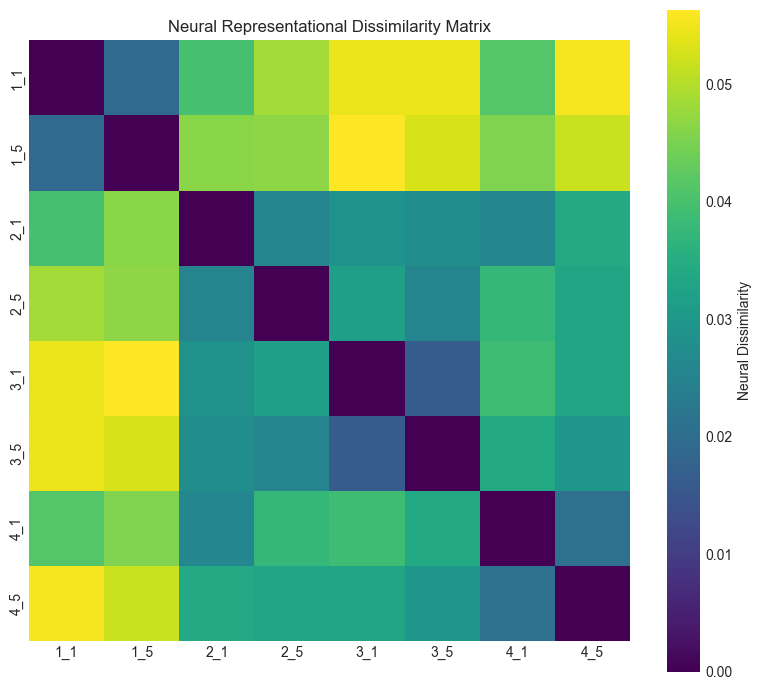

In [18]:
def compute_neural_rdm(population_matrix, metric='correlation'):
    """
    Compute representational dissimilarity matrix from neural patterns
    
    Args:
        population_matrix: conditions × neurons array
        metric: 'correlation' or 'euclidean'
    
    Returns:
        RDM: conditions × conditions dissimilarity matrix
    """
    if metric == 'correlation':
        # Compute correlation distance (1 - correlation)
        rdm = 1 - np.corrcoef(population_matrix)
        np.fill_diagonal(rdm, 0)  # Ensure diagonal is exactly 0
    else:
        # Compute pairwise distances
        rdm = squareform(pdist(population_matrix, metric=metric))
    
    return rdm

# Compute neural RDM
neural_rdm = compute_neural_rdm(population_matrix, metric='correlation')

# Visualize
plt.figure(figsize=(8, 7))
sns.heatmap(neural_rdm, 
            xticklabels=conditions,
            yticklabels=conditions,
            cmap='viridis',
            square=True,
            cbar_kws={'label': 'Neural Dissimilarity'})
plt.title('Neural Representational Dissimilarity Matrix')
plt.tight_layout()
plt.show()


## 5: Create Model RDMs


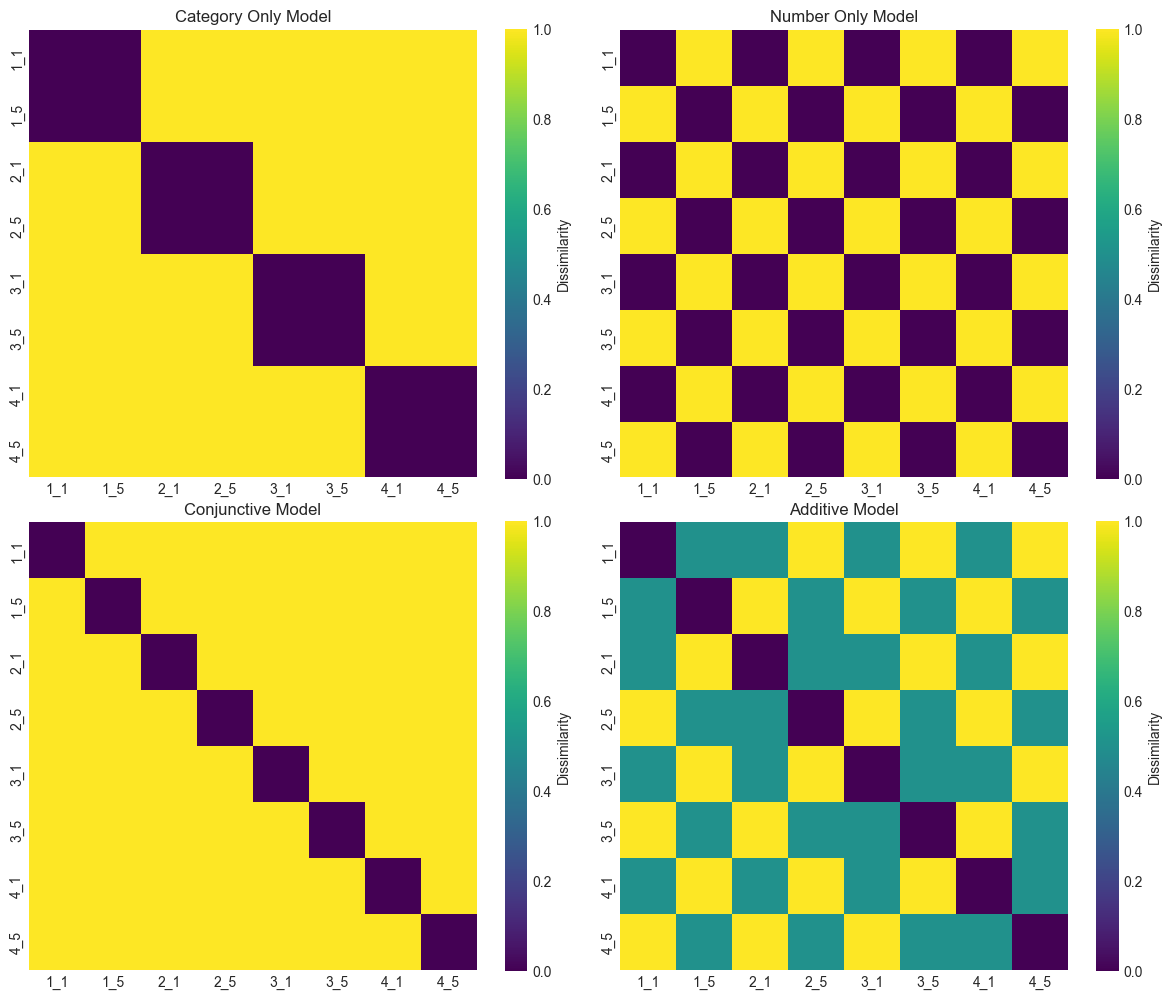

In [19]:
def create_model_rdms(conditions):
    """
    Create theoretical RDMs for different coding schemes
    """
    n_conditions = len(conditions)
    
    # Parse conditions
    parsed = []
    for cond in conditions:
        parts = cond.split('_')
        category = parts[0]
        number = int(parts[1])
        parsed.append((category, number))
    
    # Model 1: Pure Category Coding
    category_rdm = np.zeros((n_conditions, n_conditions))
    for i in range(n_conditions):
        for j in range(n_conditions):
            if parsed[i][0] != parsed[j][0]:
                category_rdm[i, j] = 1
    
    # Model 2: Pure Number Coding  
    number_rdm = np.zeros((n_conditions, n_conditions))
    for i in range(n_conditions):
        for j in range(n_conditions):
            if parsed[i][1] != parsed[j][1]:
                number_rdm[i, j] = 1
    
    # Model 3: Conjunctive Coding
    conjunctive_rdm = np.zeros((n_conditions, n_conditions))
    for i in range(n_conditions):
        for j in range(n_conditions):
            if i != j:  # Different only if completely different
                conjunctive_rdm[i, j] = 1
    
    # Model 4: Additive Coding
    additive_rdm = (category_rdm + number_rdm) / 2
    
    return {
        'Category Only': category_rdm,
        'Number Only': number_rdm,
        'Conjunctive': conjunctive_rdm,
        'Additive': additive_rdm
    }

# Create model RDMs
model_rdms = create_model_rdms(conditions)

# Visualize all models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, (model_name, model_rdm) in enumerate(model_rdms.items()):
    ax = axes[idx]
    sns.heatmap(model_rdm,
                xticklabels=conditions,
                yticklabels=conditions,
                cmap='viridis',
                square=True,
                cbar_kws={'label': 'Dissimilarity'},
                ax=ax)
    ax.set_title(f'{model_name} Model')

plt.tight_layout()
plt.show()


## 6: Compare Neural RDM with Model RDMs


RSA Results (correlation with neural RDM):
--------------------------------------------------
Category Only   r = 0.606, p = 0.0006
Additive        r = 0.348, p = 0.0692
Number Only     r = -0.080, p = 0.6842
Conjunctive     r = nan, p = nan


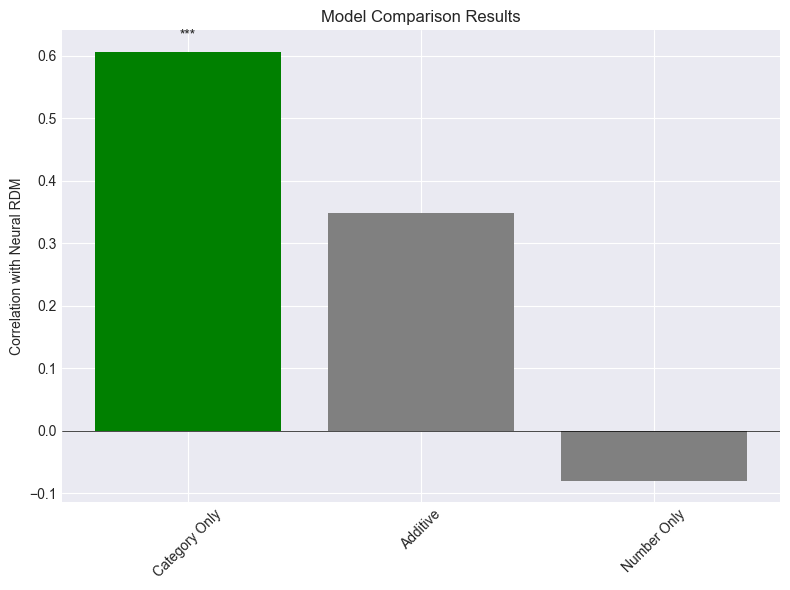

In [20]:
def compare_rdms(neural_rdm, model_rdms):
    """
    Correlate neural RDM with each model RDM
    """
    # Get upper triangular indices (excluding diagonal)
    triu_indices = np.triu_indices_from(neural_rdm, k=1)
    
    # Vectorize neural RDM
    neural_vector = neural_rdm[triu_indices]
    
    results = {}
    for model_name, model_rdm in model_rdms.items():
        # Vectorize model RDM
        model_vector = model_rdm[triu_indices]
        
        # Compute Spearman correlation
        r, p = spearmanr(neural_vector, model_vector)
        
        results[model_name] = {
            'correlation': r,
            'p_value': p
        }
    
    return results

# Run comparison
rsa_results = compare_rdms(neural_rdm, model_rdms)

# Display results
results_df = pd.DataFrame(rsa_results).T
results_df = results_df.sort_values('correlation', ascending=False)

print("RSA Results (correlation with neural RDM):")
print("-" * 50)
for model, row in results_df.iterrows():
    print(f"{model:15} r = {row['correlation']:.3f}, p = {row['p_value']:.4f}")

# Visualize
plt.figure(figsize=(8, 6))
bars = plt.bar(results_df.index, results_df['correlation'], 
                color=['green' if p < 0.05 else 'gray' 
                       for p in results_df['p_value']])
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.ylabel('Correlation with Neural RDM')
plt.title('Model Comparison Results')
plt.xticks(rotation=45)

# Add significance stars
for i, (model, row) in enumerate(results_df.iterrows()):
    if row['p_value'] < 0.001:
        plt.text(i, row['correlation'] + 0.02, '***', ha='center')
    elif row['p_value'] < 0.01:
        plt.text(i, row['correlation'] + 0.02, '**', ha='center')
    elif row['p_value'] < 0.05:
        plt.text(i, row['correlation'] + 0.02, '*', ha='center')

plt.tight_layout()
plt.show()


## 7: Cross-Decoding Analysis


In [26]:
def prepare_decoding_data(data):
    """
    Prepare data for decoding analysis
    Returns feature matrix X and labels
    """
    # Create trial × neuron matrix
    trial_neuron_matrix = data.pivot_table(
        values='fr_epoch',
        index='trial_nr',
        columns='unit_id',
        aggfunc='mean'
    ).fillna(0)
    
    # Get labels for each trial
    trial_labels = data.groupby('trial_nr').first()[
        ['first_cat_simple', 'first_num_simple']
    ]
    
    # Align with matrix
    trial_labels = trial_labels.loc[trial_neuron_matrix.index]
    
    return trial_neuron_matrix.values, trial_labels

# Prepare data
X, labels = prepare_decoding_data(data_filtered)

def cross_decode_categories(X, labels):
    """
    Test if category decoder generalizes across numbers
    """
    categories = labels['first_cat_simple'].values
    numbers = labels['first_num_simple'].values
    
    # Train on number=1, test on number=5
    train_mask = numbers == 1
    test_mask = numbers == 5
    
    # Ensure we have enough samples
    if train_mask.sum() < 4 or test_mask.sum() < 4:
        print("Warning: Not enough trials for reliable cross-decoding")
        return None
    
    # Train decoder
    clf = Pipeline([
        ('scaler', StandardScaler()),
        ('svc', SVC(kernel='linear', C=1.0))
    ])
    
    # Fit on number=1 trials
    clf.fit(X[train_mask], categories[train_mask])
    
    # Test on number=5 trials
    cross_accuracy = clf.score(X[test_mask], categories[test_mask])
    
    # For comparison: within-number decoding
    within_scores = cross_val_score(
        clf, X[test_mask], categories[test_mask], 
        cv=5, scoring='accuracy'
    )
    within_accuracy = within_scores.mean()
    
    return {
        'cross_number_accuracy': cross_accuracy,
        'within_number_accuracy': within_accuracy,
        'generalization_index': cross_accuracy / within_accuracy if within_accuracy > 0 else 0
    }

# Run cross-decoding
cross_results = cross_decode_categories(X, labels)

if cross_results:
    print("\nCross-Decoding Results (Category):")
    print("-" * 50)
    print(f"Train on num=1, test on num=5: {cross_results['cross_number_accuracy']:.3f}")
    print(f"Train and test on num=5:       {cross_results['within_number_accuracy']:.3f}")
    print(f"Generalization index:          {cross_results['generalization_index']:.3f}")
    print("\nInterpretation:")
    if cross_results['generalization_index'] > 0.8:
        print("→ Strong evidence for ABSTRACT category coding")
    elif cross_results['generalization_index'] < 0.6:
        print("→ Strong evidence for CONJUNCTIVE coding")
    else:
        print("→ Mixed or partial generalization")


## 8: Plot


In [ ]:
def create_summary_figure(neural_rdm, model_rdms, rsa_results, cross_results):
    """
    Create a comprehensive summary figure
    """
    fig = plt.figure(figsize=(16, 10))
    
    # Neural RDM
    ax1 = plt.subplot(2, 3, 1)
    sns.heatmap(neural_rdm, cmap='viridis', square=True,
                xticklabels=conditions, yticklabels=conditions,
                cbar_kws={'label': 'Dissimilarity'})
    ax1.set_title('Neural RDM', fontsize=14, fontweight='bold')
    
    # Best fitting model
    best_model = max(rsa_results, key=lambda x: rsa_results[x]['correlation'])
    ax2 = plt.subplot(2, 3, 2)
    sns.heatmap(model_rdms[best_model], cmap='viridis', square=True,
                xticklabels=conditions, yticklabels=conditions,
                cbar_kws={'label': 'Dissimilarity'})
    ax2.set_title(f'Best Model: {best_model}', fontsize=14, fontweight='bold')
    
    # Model correlations
    ax3 = plt.subplot(2, 3, 3)
    results_df = pd.DataFrame(rsa_results).T.sort_values('correlation', ascending=False)
    bars = ax3.bar(range(len(results_df)), results_df['correlation'],
                    color=['green' if p < 0.05 else 'gray' 
                           for p in results_df['p_value']])
    ax3.set_xticks(range(len(results_df)))
    ax3.set_xticklabels(results_df.index, rotation=45, ha='right')
    ax3.set_ylabel('Correlation with Neural RDM')
    ax3.set_title('Model Fits', fontsize=14, fontweight='bold')
    ax3.axhline(y=0, color='black', linewidth=0.5)
    
    # Cross-decoding results
    if cross_results:
        ax4 = plt.subplot(2, 3, 4)
        accuracies = [cross_results['cross_number_accuracy'], 
                      cross_results['within_number_accuracy']]
        labels_acc = ['Cross-number\n(train 1, test 5)', 'Within-number\n(train/test 5)']
        bars = ax4.bar(labels_acc, accuracies, color=['coral', 'skyblue'])
        ax4.axhline(y=0.5, color='black', linestyle='--', alpha=0.5, label='Chance')
        ax4.set_ylabel('Decoding Accuracy')
        ax4.set_title('Category Decoding', fontsize=14, fontweight='bold')
        ax4.set_ylim(0, 1)
        
        # Add accuracy values on bars
        for bar, acc in zip(bars, accuracies):
            ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{acc:.2f}', ha='center', va='bottom')
    
    # Interpretation text
    ax5 = plt.subplot(2, 3, 5)
    ax5.axis('off')
    
    # Build interpretation
    interpretation = "INTERPRETATION:\n\n"
    
    # RSA interpretation
    if rsa_results['Category Only']['correlation'] > 0.6:
        interpretation += "• Strong category representation\n"
    if rsa_results['Number Only']['correlation'] > 0.6:
        interpretation += "• Strong number representation\n"
    if rsa_results['Conjunctive']['correlation'] > 0.6:
        interpretation += "• Evidence for bound representations\n"
    elif rsa_results['Additive']['correlation'] > 0.6:
        interpretation += "• Features coded independently\n"
    
    # Cross-decoding interpretation
    if cross_results and cross_results['generalization_index'] > 0.8:
        interpretation += "\n• Categories generalize across numbers\n"
        interpretation += "  → Abstract category coding"
    elif cross_results and cross_results['generalization_index'] < 0.6:
        interpretation += "\n• Categories do NOT generalize\n"
        interpretation += "  → Conjunctive coding"
    
    ax5.text(0.1, 0.9, interpretation, transform=ax5.transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    return fig

# Create summary
if cross_results:
    fig = create_summary_figure(neural_rdm, model_rdms, rsa_results, cross_results)
    plt.show()


## 9: Statistical Tests and Noise Ceiling


In [ ]:
def bootstrap_rdm_correlation(neural_data, model_rdm, n_bootstrap=1000):
    """
    Bootstrap confidence intervals for RDM correlations
    """
    n_conditions = len(conditions)
    correlations = []
    
    for _ in range(n_bootstrap):
        # Resample trials with replacement
        resampled_indices = np.random.choice(
            len(data), size=len(data), replace=True
        )
        resampled_data = data.iloc[resampled_indices]
        
        # Compute RDM for resampled data
        pop_matrix = get_population_vectors(resampled_data, conditions)
        resampled_rdm = compute_neural_rdm(pop_matrix)
        
        # Correlate with model
        triu_idx = np.triu_indices_from(resampled_rdm, k=1)
        r, _ = spearmanr(resampled_rdm[triu_idx], model_rdm[triu_idx])
        correlations.append(r)
    
    # Compute confidence intervals
    ci_lower = np.percentile(correlations, 2.5)
    ci_upper = np.percentile(correlations, 97.5)
    
    return ci_lower, ci_upper

# Example: Bootstrap best model
best_model = max(rsa_results, key=lambda x: rsa_results[x]['correlation'])
ci_lower, ci_upper = bootstrap_rdm_correlation(data, model_rdms[best_model])

print(f"\nBootstrap CI for {best_model} model:")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")


## Next Steps and Extensions

1. **Temporal Dynamics**: Analyze how representations evolve over time during encoding
2. **Individual Differences**: Check if some participants use abstract vs conjunctive strategies
3. **Load Effects**: Compare low load (current analysis) vs high load conditions
4. **Regional Differences**: If you have electrode locations, compare brain regions
5. **Error Trials**: Analyze how representation quality predicts subsequent memory performance
